QDA (manual) Accuracy: 0.8252487562189055
Regression MSE: 5.0017
Regression RMSE: 2.2365
R² score: 0.8611


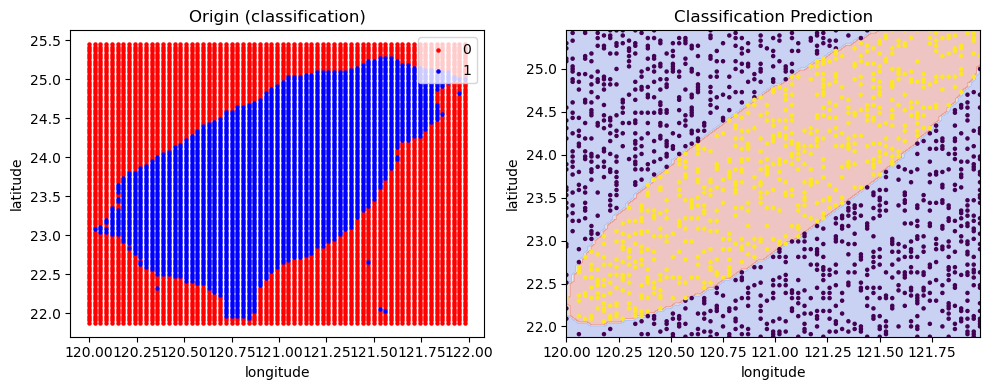

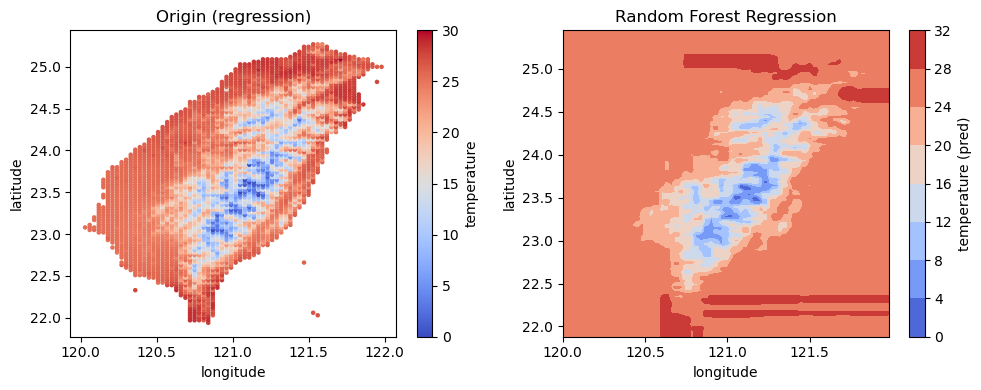

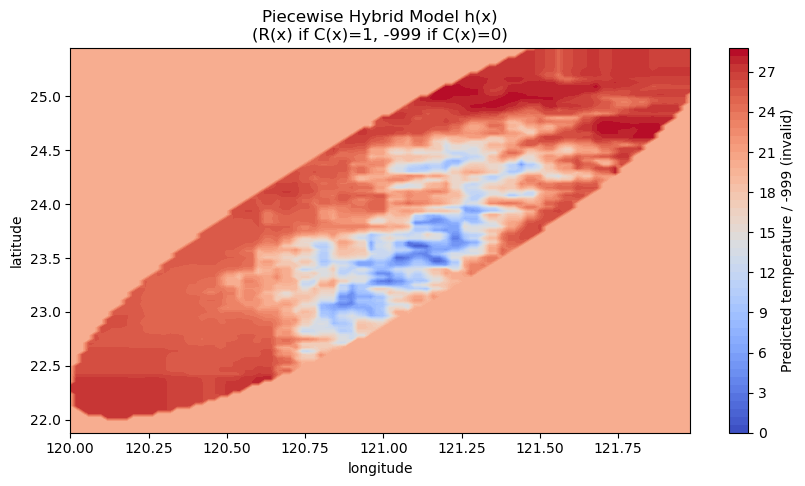

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import re
import math

# ==============================
# 讀取 XML 檔案
# ==============================
tree = ET.parse('O-A0038-003.xml')
root = tree.getroot()

# namespace
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
contents = root.findall('.//cwa:Content', ns)

# 解析數值資料
data = []
pattern = re.compile(r'[-+]?\d+\.\d+E[+-]?\d+')  # 匹配像 -999.0E+00 或 28.1E+00

for c in contents:
    text = c.text
    numbers = pattern.findall(text)
    floats = [float(x) for x in numbers]
    data.extend(floats)

# ==============================
# 生成分類與迴歸資料
# ==============================
def Classification(data, x, y):
    A = []
    k = 0
    x0 = x
    for i in range(120):
        for j in range(67):
            if (data[k] == -999.0):
                A.append([round(x, 2), round(y, 2), 0])
            else:
                A.append([round(x, 2), round(y, 2), 1])
            x += 0.03
            k += 1
        x = x0
        y += 0.03
    return A

def Regression(data, x, y):
    B = []
    k = 0
    x0 = x
    for i in range(120):
        for j in range(67):
            if (data[k] != -999.0E+00):
                B.append([round(x, 2), round(y, 2), data[k]])
            x += 0.03
            k += 1
        x = x0
        y += 0.03
    return B

class MyQDA:
    def __init__(self):
        self.mu_ = {}
        self.sigma_ = {}
        self.prior_ = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]
        for c in self.classes_:
            Xc = X[y == c]
            self.mu_[c] = np.mean(Xc, axis=0)
            self.sigma_[c] = np.cov(Xc, rowvar=False)
            self.prior_[c] = Xc.shape[0] / n_samples

    def _discriminant(self, x, c):
        mu = self.mu_[c]
        sigma = self.sigma_[c]
        prior = self.prior_[c]

        inv_sigma = np.linalg.inv(sigma)
        det_sigma = np.linalg.det(sigma)
        diff = x - mu
        term = -0.5 * np.log(det_sigma) \
               -0.5 * diff @ inv_sigma @ diff.T \
               + np.log(prior)
        return term

    def predict(self, X):
        preds = []
        for x in X:
            scores = {c: self._discriminant(x, c) for c in self.classes_}
            preds.append(max(scores, key=scores.get))
        return np.array(preds)

A = Classification(data, 120, 21.88)
B = Regression(data, 120, 21.88)

# ==============================
# 分類模型（Logistic Regression）
# ==============================
A = np.array(A)
X_class = A[:, :2]   # (經度, 緯度)
y_class = A[:, 2]    # 標籤 (0=無效, 1=有效)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# 訓練模型
clf = MyQDA()
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)
print("QDA (manual) Accuracy:", acc)

# ==============================
# 迴歸模型（改為 Random Forest）
# ==============================
B = np.array(B)
X_reg = B[:, :2]
y_reg = B[:, 2]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0)

# 使用 RandomForestRegressor
reg = RandomForestRegressor(
    n_estimators=200,   
    max_depth=None,     
    min_samples_split=2,
    random_state=0,
    n_jobs=-1           
)
reg.fit(X_train_r, y_train_r)

y_pred_r = reg.predict(X_test_r)

mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_r, y_pred_r)

print(f"Regression MSE: {mse:.4f}")
print(f"Regression RMSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")

def h(X):
    """Piecewise model combining classifier and regressor."""
    C_pred = clf.predict(X)
    R_pred = reg.predict(X)
    h_pred = np.where(C_pred == 1, R_pred, 20)
    return h_pred

# ==============================
# 視覺化分類結果
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_class[y_class==0,0], X_class[y_class==0,1], c='red', s=5, label='0')
plt.scatter(X_class[y_class==1,0], X_class[y_class==1,1], c='blue', s=5, label='1')
plt.title("Origin (classification)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend()

# 模型預測網格
lon_mesh = np.linspace(X_class[:,0].min(), X_class[:,0].max(), 100)
lat_mesh = np.linspace(X_class[:,1].min(), X_class[:,1].max(), 100)
Lon_mesh, Lat_mesh = np.meshgrid(lon_mesh, lat_mesh)
pred_class = clf.predict(np.c_[Lon_mesh.ravel(), Lat_mesh.ravel()]).reshape(Lon_mesh.shape)

plt.subplot(1,2,2)
plt.contourf(Lon_mesh, Lat_mesh, pred_class, cmap='coolwarm', alpha=0.3)
plt.scatter(X_test_c[:,0], X_test_c[:,1], c=y_pred_c, s=5)
plt.title("Classification Prediction")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.tight_layout()
plt.show()

# ==============================
# 視覺化迴歸結果 (Random Forest)
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_reg[:,0], X_reg[:,1], c=y_reg, cmap='coolwarm', s=5, vmin=0, vmax=30)
plt.title("Origin (regression)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="temperature")

# 模型預測網格
pred_temp = reg.predict(np.c_[Lon_mesh.ravel(), Lat_mesh.ravel()]).reshape(Lon_mesh.shape)
plt.subplot(1,2,2)
plt.contourf(Lon_mesh, Lat_mesh, pred_temp, cmap='coolwarm')
plt.title("Random Forest Regression")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="temperature (pred)")

plt.tight_layout()
plt.show()

lon_mesh = np.linspace(X_class[:,0].min(), X_class[:,0].max(), 100)
lat_mesh = np.linspace(X_class[:,1].min(), X_class[:,1].max(), 100)
Lon_mesh, Lat_mesh = np.meshgrid(lon_mesh, lat_mesh)
X_grid = np.c_[Lon_mesh.ravel(), Lat_mesh.ravel()]

# Predict with piecewise model
H_pred = h(X_grid).reshape(Lon_mesh.shape)

plt.figure(figsize=(10,5))
plt.contourf(Lon_mesh, Lat_mesh, H_pred, cmap='coolwarm', levels=50)
plt.title("Piecewise Hybrid Model h(x)\n(R(x) if C(x)=1, -999 if C(x)=0)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="Predicted temperature / -999 (invalid)")
plt.show()
